# Python implementation of https://arxiv.org/pdf/1909.10140.pdf

In [10]:
import numpy as np
from coef import XI_coef, XI_coef_matrix, XI_coef_matrix_parallel, x_ordered_rank, XI_numba, XI_numba_matrix
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [14]:
# A reasonably sized dataframe for Data Science cases
np_array = np.random.randint(0, 100, size=(int(1e4), 70))

# Timing

In [15]:
%time _ = np.corrcoef(np_array)

CPU times: user 1.78 s, sys: 1.55 s, total: 3.34 s
Wall time: 603 ms


In [16]:
%time _ = XI_coef_matrix(np_array)

CPU times: user 46.4 s, sys: 0 ns, total: 46.4 s
Wall time: 47.6 s


In [17]:
%time _ = XI_coef_matrix_parallel(np_array)
# On the order of 10x longer than the 'normal' numpy correlation function (on my particular system)

CPU times: user 1.27 s, sys: 144 ms, total: 1.42 s
Wall time: 10 s


In [20]:
%time _ = XI_numba_matrix(np_array)

CPU times: user 776 ms, sys: 41.3 ms, total: 817 ms
Wall time: 1.5 s


Even the numpy version can take some time on larger datasets, this new measure unfortunately(even when run in parallel) takes 10 times longer.
If you hate yourself, or actually know what you're doing, a GPU-compute version of this would be awesome.

# Explore Different Cases

## Straight line (with noise)

In [8]:
size = int(1e6)
list_1 = np.arange(0, size)
list_2 = 0.5 * np.arange(size, 0, -1) + np.random.random_sample(size) * 100

print("x->y:", XI_coef(list_1, list_2))
print("y->x:", XI_coef(list_2, list_1))
print("std coeff value:", np.corrcoef(list_1, list_2)[0,-1])

x->y: 0.9997985700429998
y->x: 0.9997989721239998
std coeff value: -0.999999979962234


Okay, they both produce approximately 1 indicating that if you know x, then you (almost) know the y-value.
It is worth noting that the std correlation coefficient goes from -1 to 1, and the new measure ONLY from 0 to 1.

## Lets see the new method with some strange cases to see if it behaves well

### All Zeros

In [9]:
np_array = np.zeros(shape=(10, 3))
print("XI coeff matrix\n", XI_coef_matrix(np_array))

XI coeff matrix
 [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


### Single value in each column

In [10]:
np_array = np.random.randint(0, 100, (1, 3))
print("XI coeff matrix\n", XI_coef_matrix(np_array))

XI coeff matrix
 [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


### 1 column is proportional to the inverse of the other

In [11]:
np_array = np.random.randint(0, 100, (1000, 2))
np_array[:, 1] = -2 * np_array[:, 0]
print("XI coeff matrix\n", XI_coef_matrix(np_array))

XI coeff matrix
 [[0.99704576 0.99703747]
 [0.99704576 0.99703747]]


In the pathological cases above nothing explodes, good.

## Explore benefits of this measure

### A sin(x) function

The new method should hopefully show that there is a relationship from x -> y, but a bad one from y -> x
The standard coefficient on the other hand is close to 0 suggesting that there is no relationship at all between them.

In [12]:
list_1 = np.arange(0, 1000, np.pi/8)
list_2 = np.sin(list_1) + np.random.random_sample(len(list_1))/10

print("x -> y: ", XI_coef(list_1, list_2))
print("y -> x: ", XI_coef(list_2, list_1))
print("std coeff: ", np.corrcoef(list_1, list_2)[0,-1])

x -> y:  0.65092995322487
y -> x:  -0.006187253437841322
std coeff:  -0.003368490513119983


Well that's nice. If you're using correlation as a means to determine which columns should/n't be dropped then the new method gives you more useful information to say that actually the x feature would be great to keep.
Alternatively, the standard correlation measure would suggest that the x column is useless and perhaps should be dropped in favour of keeping other columns (assuming there were any).

### Semi-circular Data

In [13]:
radians = np.arange(0, np.pi, 2 * np.pi/1000)
list_1 = np.sin(radians) + np.random.random_sample(len(radians))/10
list_2 = np.cos(radians) + np.random.random_sample(len(radians))/10

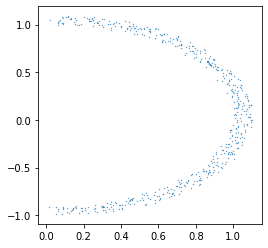

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(list_1, list_2, s=0.1)

In [15]:
print("x -> y: ", XI_coef(list_1, list_2))
print("y -> x: ", XI_coef(list_2, list_1))
print("std coeff: ", np.corrcoef(list_1, list_2)[0,-1])

x -> y:  0.1860727442909783
y -> x:  0.8023472093888379
std coeff:  -0.010020034541798208


Again, the standard correlation coefficient suggests no relationship between the two columns, whereas this new method says that if you know y, you have a great understanding of what the x value is. However, while knowledge of x does provide some information, it is ambiguous as to exactly which value y will be.

## Let's try a full circle this time

In [16]:
radians = np.arange(0, 2*np.pi, 2 * np.pi/1000)
list_1 = np.sin(radians) + np.random.random_sample(len(radians))/10
list_2 = np.cos(radians) + np.random.random_sample(len(radians))/10
print("x -> y: ", XI_coef(list_1, list_2))
print("y -> x: ", XI_coef(list_2, list_1))
print("std coeff: ", np.corrcoef(list_1, list_2)[0,-1])

x -> y:  0.19728319728319843
y -> x:  0.22029022029022127
std coeff:  -0.0032914408465579007


Okay, now the ambiguity runs both ways from y to x and x to y.

In [63]:
#If you wish to see where the time is being spent on computing this coefficient
%lprun -f XI_coef_matrix XI_coef_matrix(np_array)

In [4]:
# A reasonably sized dataframe for Data Science cases
np_array = np.random.randint(0, 100, size=(int(1e6), 2))

In [5]:
#Compile the numba version
_ = XI_numba(np_array[0:10,-1], np_array[0:10,-1])

In [6]:
%time _ = XI_coef(np_array[:,0], np_array[:,1])

CPU times: user 1.91 s, sys: 62.4 ms, total: 1.97 s
Wall time: 1.97 s


In [7]:
%time _ = XI_numba(np_array[:,0], np_array[:,1])

CPU times: user 259 ms, sys: 7.52 ms, total: 266 ms
Wall time: 265 ms


In [8]:
%time _ = np.corrcoef(np_array[:,0],np_array[:,1])

CPU times: user 16.5 ms, sys: 12.2 ms, total: 28.7 ms
Wall time: 24.1 ms
